In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import os
import math
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Question 2:

Use the data file provided here. This has been taken from Microsoft learning to rank dataset, which can
be found here. Read about the dataset carefully, and what all it contains.
1. Consider only the queries with qid:4 and the relevance judgement labels as relevance score.
2. (10 points) Make a file rearranging the query-url pairs in order of max DCG. State how many such files could be made.
3. (5 points) Compute nDCG
    (a) At 50
    (b) For the whole dataset
4. (10 points) Assume a model that simply ranks URLs on the basis of the value of feature 75 (sum of TF-IDF on the whole document) i.e. the higher the value, the more relevant the URL. Assume any non zero relevance judgment value to be relevant. Plot a Precision-Recall curve for query “qid:4”.

In [2]:
with open('IR-assignment-2-data.txt') as f:
    lines = f.readlines()

In [3]:
lines[0].strip()

'0 qid:4 1:3 2:0 3:2 4:0 5:3 6:1 7:0 8:0.666667 9:0 10:1 11:999 12:0 13:110 14:5 15:1114 16:14.976692 17:28.949002 18:25.594644 19:28.531344 20:14.972391 21:20 22:0 23:5 24:0 25:25 26:1 27:0 28:0 29:0 30:1 31:12 32:0 33:4 34:0 35:16 36:6.666667 37:0 38:1.666667 39:0 40:8.333333 41:20.222222 42:0 43:2.888889 44:0 45:37.555556 46:0.02002 47:0 48:0.045455 49:0 50:0.022442 51:0.001001 52:0 53:0 54:0 55:0.000898 56:0.012012 57:0 58:0.036364 59:0 60:0.014363 61:0.006673 62:0 63:0.015152 64:0 65:0.007481 66:0.00002 67:0 68:0.000239 69:0 70:0.00003 71:77.577533 72:0 73:30.667985 74:0 75:90.53171 76:5.52713 77:0 78:0 79:0 80:5.526745 81:57.882066 82:0 83:18.750101 84:0 85:66.125373 86:25.859178 87:0 88:10.222662 89:0 90:30.177237 91:525.177766 92:0 93:60.031269 94:0 95:675.850674 96:1 97:0 98:0 99:0 100:1 101:0.875901 102:0 103:0.66135 104:0 105:0.864571 106:28.756809 107:0 108:3.274639 109:0 110:28.985515 111:-17.640291 112:-29.251906 113:-20.596041 114:-31.107208 115:-17.519629 116:-19.440921

### 1.

In [4]:
relevance = []
queryId = []
features = [[] for _ in range(136)]
# For each line in dataset.
for line in lines:
    tokens = line.strip().split()
    
    #Query Id:
    qId = int(tokens[1].split(":")[1])
    
    # Only take Qid of 4.
    if (qId == 4):
        queryId.append(qId) # Query Id
        relevance.append(int(tokens[0])) # Relevance of document
        # For other features.
        for feat in tokens[2:]:
            featNo = int(feat.split(":")[0])
            featValue = float(feat.split(":")[1])
            features[featNo-1].append(featValue)

In [5]:
df = pd.DataFrame.from_dict({'relevance': relevance, 'queryId': queryId})
for idx,feature in enumerate(features):
    df['{}'.format(idx+1)] = feature

In [6]:
df.head()

,relevance,queryId,1,2,3,4,5,6,7,8,...,127,128,129,130,131,132,133,134,135,136
0,0,4,3.0,0.0,2.0,0.0,3.0,1.0,0.0,0.666667,...,27.0,2.0,9.0,124.0,4678.0,54.0,74.0,0.0,0.0,0.00
1,0,4,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.000000,...,61.0,0.0,8.0,122.0,508.0,131.0,136.0,0.0,0.0,0.00
2,0,4,3.0,0.0,2.0,0.0,3.0,1.0,0.0,0.666667,...,31.0,2.0,8.0,115.0,508.0,51.0,70.0,0.0,0.0,0.00
3,0,4,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.000000,...,32.0,82.0,17.0,122.0,508.0,83.0,107.0,0.0,10.0,13.35
4,1,4,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.000000,...,29.0,11.0,8.0,121.0,508.0,103.0,120.0,0.0,0.0,0.00


In [7]:
df.shape

(103, 138)

### 2.

- In DCG - summation i=1 to n (relevance of i/ log2(i+1)).
- DCG is maximum when highest relevance document is obtained first i.e maximum rank value is at the top.
- Inorder to get number of such arrangements, we just see how many documents have same relevance number and multiply the permutation of each.

In [8]:
dfMaxRel = df.copy(deep=True)
dfMaxRel = dfMaxRel.sort_values(by='relevance', ascending=False)
dfMaxRel.to_csv('q2-2.csv', index_label='retrieval index')
dfMaxRel.head()

,relevance,queryId,1,2,3,4,5,6,7,8,...,127,128,129,130,131,132,133,134,135,136
7,3,4,3.0,0.0,2.0,1.0,3.0,1.000000,0.000000,0.666667,...,32.0,349.0,8.0,123.0,281.0,22.0,6.0,0.0,0.0,0.000000
76,2,4,2.0,0.0,1.0,0.0,2.0,0.666667,0.000000,0.333333,...,19.0,0.0,0.0,2417.0,721.0,14.0,113.0,0.0,13.0,47.900000
40,2,4,3.0,2.0,2.0,0.0,3.0,1.000000,0.666667,0.666667,...,33.0,8.0,3.0,1888.0,9338.0,3.0,11.0,0.0,0.0,0.000000
36,2,4,3.0,0.0,2.0,0.0,3.0,1.000000,0.000000,0.666667,...,17.0,0.0,2.0,12028.0,11379.0,26.0,24.0,0.0,77.0,23.959522
90,2,4,3.0,0.0,3.0,3.0,3.0,1.000000,0.000000,1.000000,...,67.0,27.0,0.0,814.0,13555.0,108.0,113.0,0.0,0.0,0.000000


In [10]:
dfMaxRel['relevance'].unique()

array([3, 2, 1, 0])

In [11]:
dfMaxRel['relevance'].value_counts()

0    59
1    26
2    17
3     1
Name: relevance, dtype: int64

In [12]:
print("Number of unique arrangements with maximum DCG Values: ")
math.factorial(59) * math.factorial(26) * math.factorial(17) * 1

Number of unique arrangements with maximum DCG Values: 


19893497375938370599826047614905329896936840170566570588205180312704857992695193482412686565431050240000000000000000000000

### 3.

In [16]:
def NDCG(samples):
    # Get the number of samples for which the DCG has to be calculated.
    docs = list(df['relevance'])[:samples]
    
    # Calculate the DCG.
    DCG = 0
    for idx,rel in enumerate(docs):
        DCG += (rel*1.0)/math.log2(idx+2)
        
    print(DCG)
        
    # Calculate the best DCG possible by sorting the relevance of docs in reversed order.
    docs.sort(reverse=True)
    
    BestDCG = 0
    for idx,rel in enumerate(docs):
        BestDCG += (rel*1.0)/math.log2(idx+2)
        
    print(BestDCG)
    
    # Divide by best DCG to get nDCG.
    return DCG/BestDCG

In [17]:
NDCG(50)

7.1945022763139805
12.58382772001186


0.5717260627203818

In [18]:
NDCG(103)

12.337484420604603
19.407247618668023


0.6357153091990775

### 4.

In [19]:
df2 = df[['relevance', '75']].copy(deep=True)
df2['relevant'] = df2['relevance'] > 0
df2.head()

,relevance,75,relevant
0,0,90.531710,False
1,0,538.388954,False
2,0,88.171761,False
3,0,144.564444,False
4,1,142.589323,True


In [20]:
allRelevantDocs = df2['relevant'].sum()
print(allRelevantDocs)

44


In [21]:
precisionK = []
recallK = []
relevantCountK = 0

# For all docs
for idx, rel in enumerate(list(df2['relevant'])):
    if rel == True:
        relevantCountK += 1
    
    # Precision@K
    precisionK.append(relevantCountK/(idx+1))
    # Recall@K
    recallK.append(relevantCountK/allRelevantDocs)

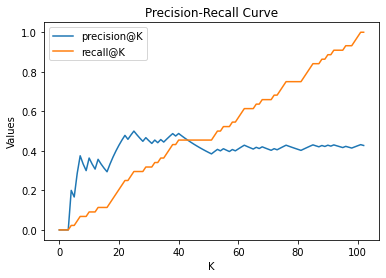

In [22]:
plt.plot(range(len(precisionK)), precisionK, label='precision@K')
plt.plot(range(len(recallK)), recallK, label='recall@K')
plt.xlabel('K')
plt.ylabel('Values')
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Question 3:

Download the 20 newsgroup. You need to pick documents of comp.graphics, sci.med, talk.politics.misc,
rec.sport.hockey, sci.space [5 classes] for text classification.
<br>
Implement the Naive Bayes algorithm for text classification using TF-ICF, (a modification of TF-
IDF) as a feature selection technique.
<br>
TF-ICF score for a given term belonging to a class can be calculated as follows:
<br>
Term Frequency (TF): Number of occurrences of a term in all documents of a particular class Class
<br>
Frequency (CF): Number of classes in which that term occurs
<br>
Inverse-Class Frequency (ICF): log( N / CF), where N represents the number of classes
<br>
Implementation Points:
1. Perform suitable pre-processing steps for the given dataset.
2. Split your dataset randomly into train: test ratio. You need to select the documents randomly for splitting. You are not supposed to split documents in sequential order, for instance, choosing the first 800 documents in the train set and last 200 in the test set for the train: test ratio of 80:20.
3. Implement the TF-ICF scoring technique for efficient feature selection. Select the top k features for each class. Subsequently, the effective vocabulary shall be the union of the top k features of each class.
4. For each class, train your Naive Bayes Classifier on the training data.
5. Test your classifier on testing data and report the confusion matrix and overall accuracy.
6. Perform the above steps on 50:50, 70:30, and 80:20 training and testing split ratios.
7. Analyze the performance of the classification algorithm for the feature selection technique across dif- ferent train: test ratios.

In [23]:
# 5 Classes
mapping = {
    'comp.graphics': 0,
    'sci.med': 1,
    'talk.politics.misc': 2,
    'rec.sport.hockey': 3,
    'sci.space': 4
}

reverseMapping = {
    0: 'comp.graphics',
    1: 'sci.med',
    2: 'talk.politics.misc',
    3: 'rec.sport.hockey',
    4: 'sci.space'
}

In [24]:
rootDir = "./20_newsgroups/"

files = []
labels = []

# For subfolders in folders.
for folder in os.listdir(rootDir):
    # only requested folders.
    if folder in mapping:
        print(folder)
        # For each file in folder.
        for file in os.listdir(rootDir + folder + "/"):
            try:
                # Try reading as text file.
                f = open(rootDir + folder + "/" + file)
                files.append(f.read())
                labels.append(mapping[folder])
            except:
                # Failed for text file, try as binary file.
                f = open(rootDir + folder + "/" + file, "rb")
                files.append(f.read().decode('utf-8', 'backslashreplace'))
                labels.append(mapping[folder])
        print("Done")
        
files = np.array(files)
labels = np.array(labels)

rec.sport.hockey
Done
sci.med
Done
talk.politics.misc
Done
comp.graphics
Done
sci.space
Done


### 1.

In [25]:
lemmatizer = WordNetLemmatizer() 
stopWords = set(stopwords.words('english'))

In [26]:
def preprocess(text):
    # Keep only alphabets and numbers
    text = re.sub(r'[^a-zA-Z0-9]+', ' ', text)
    # Convert to lower case:
    text = text.lower()
    # Stopword removal
    text = [word for word in text.split() if word not in stopWords]
    # Remove words with length <= 2
    text = [word for word in text if len(word) > 2]
    # Lemmatize
    text = [lemmatizer.lemmatize(word) for word in text]    #lemmatize the words
    return " ".join(text).strip()

In [27]:
for idx,file in enumerate(files):
    files[idx] = preprocess(file)

In [28]:
files[0]

'newsgroups rec sport hockey path cantaloupe srv cmu edu crabapple srv cmu edu bb3 andrew cmu edu news sei cmu edu ci ohio state edu magnus ac ohio state edu zaphod mp ohio state edu uwm edu utexas edu utnut alchemy chem utoronto golchowy golchowy alchemy chem utoronto gerald olchowy subject result april message 1993apr20 013439 25968 alchemy chem utoronto organization university toronto chemistry department reference 1993apr19 105815 1848 ericsson 1993apr19 211406 22528 iscnvx lmsc lockheed com date tue apr 1993 gmt line article 1993apr19 211406 22528 iscnvx lmsc lockheed com spiegel sgi413 msd lmsc lockheed com mark spiegel writes according murky news team usa roster name team played 1992 listed goalie forward tony amonte new york ranger ted drury harvard univ rob gaudreau san jose shark craig johnson univ minnesota jeff lazaro ottawa senator mike modano minnesota north star olczyk new york ranger derek plante univ minnesota duluth shion podein edmonton oiler david sacco boston unive

### 2.

In [29]:
#np.random.choice(80, size=50)
def randomSplit(splitRatio = 0.8):
    # Compute length
    dataLen = files.shape[0]
    trainDataLen = int(dataLen * splitRatio)
    
    # Get train indices randomly.
    trainIndices = np.random.choice(dataLen, size=trainDataLen)
    
    # Get train data.
    trainData = files[trainIndices]
    trainLabels = labels[trainIndices]
    
    # Get test data.
    testData = files[np.setdiff1d(range(dataLen), trainIndices)]
    testLabels = labels[np.setdiff1d(range(dataLen), trainIndices)]
    
    # return data
    return (trainData, trainLabels, testData, testLabels)

In [30]:
train, trainLabel, test, testLabel = randomSplit()
print("Train Size: ", len(train), len(trainLabel))
print("Test Size: ", len(test), len(testLabel))

Train Size:  4000 4000
Test Size:  2259 2259


### 3.

In [32]:
# Class frequency - number of classes in which a term appears.
CF = {}
# for all text
for idx,text in enumerate(train):
    for word in text.split(" "):
        if word not in CF:
            CF[word] = set()
        # Add the class.
        CF[word].add(labels[idx])

In [33]:
# ICF calculation.
ICF = {}
for word in CF.keys():
    ICF[word] = math.log(5/len(CF[word]))

In [35]:
# Term Frequency - Number of occurrences of a term in all documents of a particular class
TF = {
    0: {},
    1: {},
    2: {},
    3: {},
    4: {}
}
# calculate term frequency of each word in each class.
for idx,text in enumerate(train):
    for word in text.split(" "):
        if word not in TF[trainLabel[idx]]:
            TF[trainLabel[idx]][word] = 0
        TF[trainLabel[idx]][word] += 1

In [36]:
TFICF = {}
for i in range(5):
    TFICF[i] = {}
    for word in TF[i]:
        TFICF[i][word] = TF[i][word] * ICF[word]

In [37]:
# Select words with highest values of 
def selectKFeatures(k = 100):
    features = set()
    for i in range(5):
        x = list(dict(sorted(TFICF[i].items(), key=lambda y: y[1], reverse=True)).keys())
        features = features.union(set(x[:k]))
    return features

In [38]:
k = int(input("Enter k (# of features): "))

Enter k (# of features): 200


In [40]:
newVocab = selectKFeatures(k)
newVocab

{'000',
 '1993',
 '1993apr15',
 '1993apr16',
 '1993apr20',
 '24bit',
 '30pm',
 'abortion',
 'access',
 'activism',
 'address',
 'administration',
 'aid',
 'alaska',
 'alchemy',
 'algorithm',
 'also',
 'alt',
 'american',
 'amiga',
 'an',
 'analysis',
 'andrew',
 'animation',
 'another',
 'anyone',
 'anything',
 'application',
 'apr',
 'april',
 'around',
 'article',
 'astro',
 'astronomy',
 'aurora',
 'available',
 'back',
 'bank',
 'batf',
 'believe',
 'berkeley',
 'best',
 'better',
 'billion',
 'binary',
 'bit',
 'blue',
 'body',
 'book',
 'bos',
 'boston',
 'bruin',
 'buf',
 'buffalo',
 'bus',
 'cal',
 'calgary',
 'caltech',
 'canada',
 'cancer',
 'cantaloupe',
 'card',
 'care',
 'case',
 'cause',
 'cell',
 'center',
 'cesarean',
 'chem',
 'chi',
 'chicago',
 'child',
 'ci',
 'clarkson',
 'clayton',
 'clinton',
 'club',
 'cmu',
 'coach',
 'code',
 'color',
 'columbia',
 'com',
 'come',
 'commercial',
 'comp',
 'computer',
 'conference',
 'cooking',
 'cost',
 'could',
 'country',
 '

In [41]:
len(newVocab)

535

In [42]:
def generateNewData(data, vocab):
    newData = []
    for text in data:
        newText = []
        for word in text.split(" "):
            if word in vocab:
                newText.append(word)
        newData.append(" ".join(newText).strip())
        
    return newData

In [43]:
def generateFeatures(tr, te):
    vect = TfidfVectorizer()
    X_tr = vect.fit_transform(tr)
    X_te = vect.transform(te)
    return (X_tr, X_te)

In [44]:
train = generateNewData(train, newVocab)
test = generateNewData(test, newVocab)

In [45]:
(train, test) = generateFeatures(train, test)

In [46]:
train.shape

(4000, 535)

### 4.

In [47]:
class GNB:
    # Get mean and variance of each class.
    def getMeanAndVariance(self, data, labs):
        self.means = []
        # Mean of every class.
        self.means.append(np.mean(data[np.where(labs == 0)[0]], axis=0))
        self.means.append(np.mean(data[np.where(labs == 1)[0]], axis=0))
        self.means.append(np.mean(data[np.where(labs == 2)[0]], axis=0))
        self.means.append(np.mean(data[np.where(labs == 3)[0]], axis=0))
        self.means.append(np.mean(data[np.where(labs == 4)[0]], axis=0))
        
        # Variance of every class.
        self.variances = []
        self.variances.append(np.var(data[np.where(labs == 0)[0]], axis=0))
        self.variances.append(np.var(data[np.where(labs == 1)[0]], axis=0))
        self.variances.append(np.var(data[np.where(labs == 2)[0]], axis=0))
        self.variances.append(np.var(data[np.where(labs == 3)[0]], axis=0))
        self.variances.append(np.var(data[np.where(labs == 4)[0]], axis=0))
    
    # Get probability given a sample.
    def probability(self, sample, lab):
        # get mean and variance for the class.
        m = self.means[lab]
        v = self.variances[lab]
        # Gausssian Probability.
        x = np.exp((-1/2) * ((sample - m)**2)/(2 * v + 0.00000000001)) # Added a very small value to avoid zero div
        y = np.sqrt(2 * np.pi * v)
        return x/(y + 0.00000000001) # Added a very small value to avoid zero div.
    
    # Prior probabilities of classes.
    def prior(self, data, labs):
        self.priors = []
        self.priors.append(data[np.where(labs == 0)[0]].shape[0] / data.shape[0])
        self.priors.append(data[np.where(labs == 1)[0]].shape[0] / data.shape[0])
        self.priors.append(data[np.where(labs == 2)[0]].shape[0] / data.shape[0])
        self.priors.append(data[np.where(labs == 3)[0]].shape[0] / data.shape[0])
        self.priors.append(data[np.where(labs == 4)[0]].shape[0] / data.shape[0])
        
    # Posterior probability of each class given a sample.
    def posterior(self, sample):
        self.posteriors = []
        for classLabel in range(5):
            p = np.log(self.priors[classLabel]) # Log for stability.
            prob = np.sum(np.log(self.probability(sample, classLabel))) # log for stability.
            self.posteriors.append(p + prob) # Multiplication changes to addition as log is taken.
            
    
    # Fit the model.
    def fit(self, data, labs):
        self.getMeanAndVariance(data, labs)
        self.prior(data, labs)
        
    # Predict on samples.
    def predict(self, data):
        predictions = []
        for sample in data:
            self.posterior(sample)
            predictions.append(np.argmax(self.posteriors))
        return predictions

In [48]:
g = GNB()

In [49]:
g.fit(train.toarray(), trainLabel)

In [50]:
x = g.predict(train.toarray())
y = g.predict(test.toarray())

<ipython-input-47-5a48a512f499>:44: RuntimeWarning: divide by zero encountered in log
  prob = np.sum(np.log(self.probability(sample, classLabel))) # log for stability.


### 5.

In [51]:
print("Train Accuracy: ", sum(x == trainLabel)/len(trainLabel))
print("Test Accuracy: ", sum(y == testLabel)/len(testLabel))

Train Accuracy:  0.95725
Test Accuracy:  0.882248782647189


In [52]:
def confusionMatrix(y_true, y_pred):
    d = pd.DataFrame(columns=[0,1,2,3,4], index=[0,1,2,3,4], dtype="int")
    d.loc[:,:] = 0
    for i in range(len(y_true)):
        p = y_true[i]
        q = y_pred[i]
        d.loc[int(p),int(q)] += 1
    plt.figure(figsize=(9,7))
    plt.title("Confusion Matrix")
    ax = sns.heatmap(d, annot=True, fmt='g', xticklabels=[
        reverseMapping[0],
        reverseMapping[1],
        reverseMapping[2],
        reverseMapping[3],
        reverseMapping[4]
    ], yticklabels=[
        reverseMapping[0],
        reverseMapping[1],
        reverseMapping[2],
        reverseMapping[3],
        reverseMapping[4]
    ])
    ax.set(xlabel="Predicted Values", ylabel="Actual Values")
    plt.show()

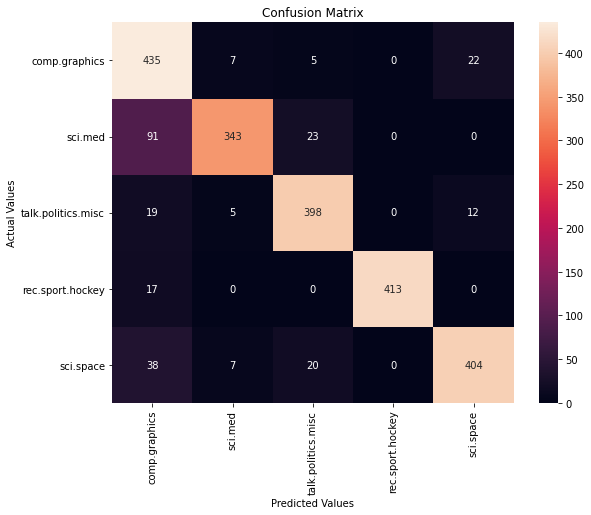

In [53]:
confusionMatrix(testLabel,y)

### 6.

##### 50-50 Split

Train Size:  2500 2500
Test Size:  3041 3041


<ipython-input-47-5a48a512f499>:44: RuntimeWarning: divide by zero encountered in log
  prob = np.sum(np.log(self.probability(sample, classLabel))) # log for stability.


Train Accuracy:  0.9508
Test Accuracy:  0.860243341006248


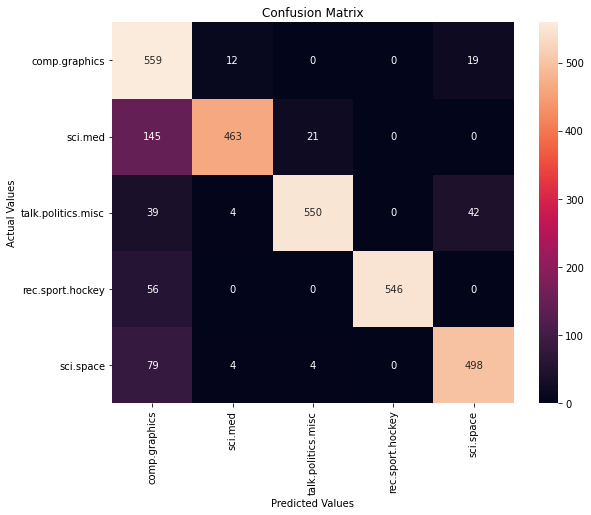

In [54]:
train, trainLabel, test, testLabel = randomSplit(0.5)
print("Train Size: ", len(train), len(trainLabel))
print("Test Size: ", len(test), len(testLabel))
train = generateNewData(train, newVocab)
test = generateNewData(test, newVocab)
(train, test) = generateFeatures(train, test)
g = GNB()
g.fit(train.toarray(), trainLabel)
x = g.predict(train.toarray())
y = g.predict(test.toarray())
print("Train Accuracy: ", sum(x == trainLabel)/len(trainLabel))
print("Test Accuracy: ", sum(y == testLabel)/len(testLabel))
confusionMatrix(testLabel,y)

##### 70-30 split

Train Size:  3500 3500
Test Size:  2484 2484


<ipython-input-47-5a48a512f499>:44: RuntimeWarning: divide by zero encountered in log
  prob = np.sum(np.log(self.probability(sample, classLabel))) # log for stability.


Train Accuracy:  0.92
Test Accuracy:  0.8534621578099839


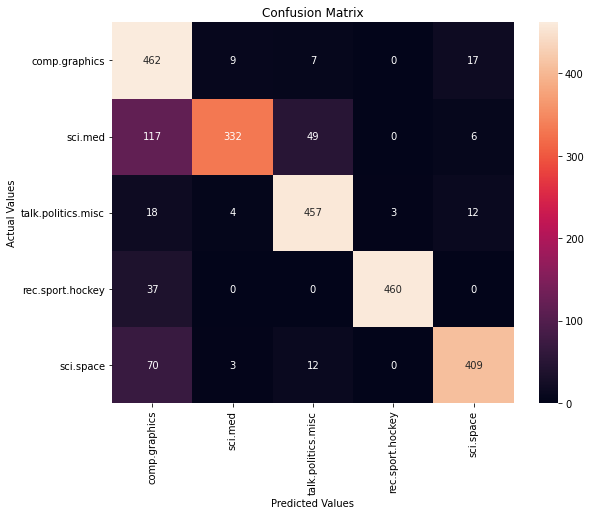

In [55]:
train, trainLabel, test, testLabel = randomSplit(0.7)
print("Train Size: ", len(train), len(trainLabel))
print("Test Size: ", len(test), len(testLabel))
train = generateNewData(train, newVocab)
test = generateNewData(test, newVocab)
(train, test) = generateFeatures(train, test)
g = GNB()
g.fit(train.toarray(), trainLabel)
x = g.predict(train.toarray())
y = g.predict(test.toarray())
print("Train Accuracy: ", sum(x == trainLabel)/len(trainLabel))
print("Test Accuracy: ", sum(y == testLabel)/len(testLabel))
confusionMatrix(testLabel,y)

### 7.

#### For 80-20 Split:
Train Accuracy:  0.95 <br>
Test Accuracy:  0.88

#### For 50-50 Split:
Train Accuracy:  0.95 <br>
Test Accuracy:  0.86

#### For 70-30 Split:
Train Accuracy:  0.92 <br>
Test Accuracy:  0.85

- Accuracy across all 3 kinds of split seem similar.
- comp.grahics class seems to be the hardest class to classify. As there are multiple mistakes being made for it. The precision for this class is lower than other classes.
- sci.med class seems to have highest precision across all splits.